# **Recommender Systems and Personalization Datasets**

### Introduzione

Lo scopo di questa analisi è andare a sviluppare un sistema di raccomandazione che, in base alle precedenti valutazioni di un utente, gli suggerisca dei risultati che possono essere interessanti per lui grazie all'analisi di altri utenti con caratteristiche simili.

### Dati

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gzip

# Surprise e Scikit-Learn

In [33]:
# Funzioni per importare file con estensione '.gz'.
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')



# I dataset contengono recensiani di capi di abbigliamento acquistati su ModCloth e RentTheRunway.
ModCloth = getDF('data/modcloth_final_data.json.gz')

# These datasets contain attributes about products sold on ModCloth and Amazon which may be sources of bias in recommendations (in particular, attributes about how the products are marketed). Data also includes user/item interactions for recommendation.
MarketBias = pd.read_csv('data/df_modcloth.csv')

---
## 1) Analisi Esplorativa (statistiche descrittive, analisi correlazione)

### <u>Preprocessing e Analisi Descrittiva (`ModCloth`)</u>

#### Dataset

In [4]:
ModCloth.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29,7,5.0,d,38,34,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31,13,3.0,b,30,36,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30,7,2.0,b,NaN,32,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.00,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


Variabili:
- **item_id**: unique product id
- **waist**: waist measurement of customer
- **size**: the standardized size of the product
- **quality**: rating for the product
- **cup size**: cup size measurement of customer
- **hips**: hip measurement of customer
- **bra size**: bra size of customer
- **category**: the category of the product
- **bust**: bust measurement of customer
- **height**: height of the customer
- **length**: feedback on the length of the product
- **fit**: fit feedback
- **user_name**: a unique id for the customer
- **shoe size**: shoe size of the customer
- **shoe width**: shoe width of the customer
- **review_text**: review of customer
- **review_summary**: review summary

In [5]:
print(f'Numero di transazioni: {ModCloth.shape[0]}')
print(f'Numero di utenti: {len(ModCloth.user_id.unique())}')
print(f'Numero di prodotti: {len(ModCloth.item_id.unique())}')

Numero di transazioni: 82790
Numero di utenti: 47958
Numero di prodotti: 1378


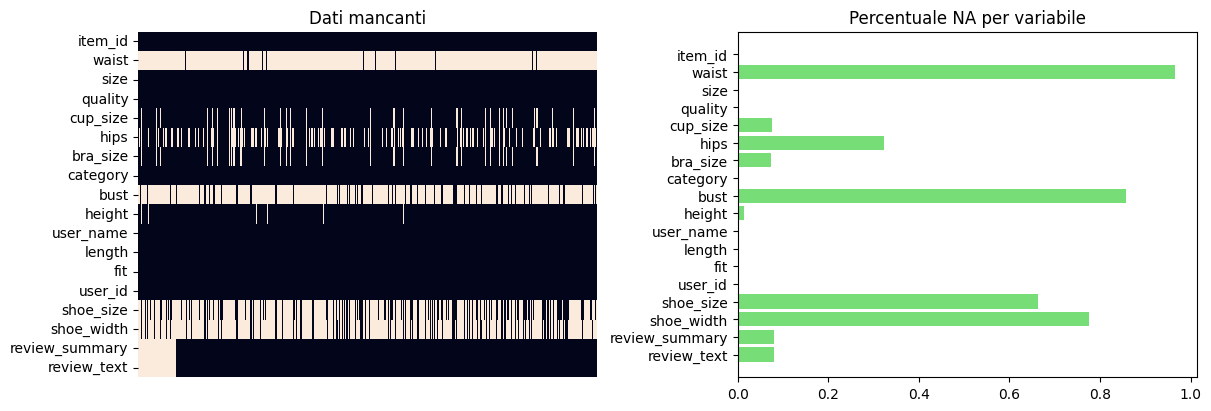

Percentuale di dati mancanti per ogni variabile:


,review_text,review_summary,shoe_width,shoe_size,user_id,fit,length,user_name,height,bust,category,bra_size,hips,cup_size,quality,size,waist,item_id
0,0.08123,0.08123,0.775251,0.662822,0.0,0.0,0.000423,0.0,0.013371,0.856818,0.0,0.07269,0.322817,0.075553,0.000821,0.0,0.965189,0.0


Struttura delle variabili:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82790 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         82790 non-null  object 
 1   waist           2882 non-null   object 
 2   size            82790 non-null  int64  
 3   quality         82722 non-null  float64
 4   cup_size        76535 non-null  object 
 5   hips            56064 non-null  object 
 6   bra_size        76772 non-null  object 
 7   category        82790 non-null  object 
 8   bust            11854 non-null  object 
 9   height          81683 non-null  object 
 10  user_name       82790 non-null  object 
 11  length          82755 non-null  object 
 12  fit             82790 non-null  object 
 13  user_id         82790 non-null  object 
 14  shoe_size       27915 non-null  object 
 15  shoe_width      18607 non-null  object 
 16  review_summary  76065 non-null  object 
 17  revi

In [6]:
# Rinominiamo le colonne per eliminare gli spazi tra le parole dei nomi delle variabili.
ModCloth.columns = ['item_id', 'waist', 'size', 'quality', 'cup_size', 'hips', 'bra_size',
                    'category', 'bust', 'height', 'user_name', 'length', 'fit', 'user_id',
                    'shoe_size', 'shoe_width', 'review_summary', 'review_text']


# Visualizzazione valori mancanti.
fig, (ax1, ax2)= plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(12, 4)

# Grafico posizione dati mancati.
sns.heatmap(ax = ax1, data=ModCloth.isna().transpose(), cbar=False)
ax1.set(title='Dati mancanti', xlabel=None)
ax1.set_xticks([])

# Grafico percentuale dati mancanti.
perc_NA = pd.DataFrame(ModCloth.isna().sum() / ModCloth.shape[0])[::-1]
ax2.barh(np.arange(len(perc_NA.index)), perc_NA[0].to_list(), color = '#77DD77')
ax2.set(title='Percentuale NA per variabile')
ax2.set_yticks(np. arange(len(perc_NA)), perc_NA.index)
plt.show()


print('Percentuale di dati mancanti per ogni variabile:')
display(perc_NA.T)

print('Struttura delle variabili:')
ModCloth.info()

Delle 18 variabili presenti nel dataset solo 6 non presentano valori mancanti: queste variabili sono valori inseriti automaticamente all'interno della recensione mentre tutti gli altri devono essere compilati dall'utente.

3 variabili hanno una percentuale di dati mancanti minore o intorno all'1% per cui possiamo semplicemente eliminarli.

2 variabili hanno una valore di adti mancanti superiore all'80%: risultano perciò poco utili per la nostra analisi.

Le altre variabili presentano vari dati mancanti di cui ci andremo ad occupare più nello specifico di seguito.

In [11]:
# Eliminiamo le righe del dataframe che si ripetono ce ne sono (377).
ModCloth.duplicated().sum()  # ---> 377
ModCloth = ModCloth.drop_duplicates()

# Eliminiamo le colonne superflue.
ModCloth.drop(['waist', 'bust'], axis=1, inplace=True)

# Eliminiamo poche righe con valori mancanti per "length", "height" e "quality".
ModCloth.dropna(subset=['length', 'height', 'quality'], inplace=True)

377


#### Variabili

In [ ]:
# Funzione che restituisce etichette e altezze del barplot per una variabile categorica.
def barplot_attr(col):
    label = col.value_counts().index
    h = col.value_counts().values
    return label, h

*Size*

Vediamo come la distribuzione di questa variabile è molto concentrata su valori bassi compresi tra 5 e 15 ma presenta altre zone, verso valori più alti, con maggiore frequenza. Questo fatto probabilmente è dovuto alla presenza di capi differenzi all'interno del dataset che perciò hanno misure differenti (es. una scarpe e un abito hanno misure differenti).

count    81219.000000
mean        12.624829
std          8.252160
min          0.000000
25%          8.000000
50%         12.000000
75%         15.000000
max         38.000000
Name: size, dtype: float64


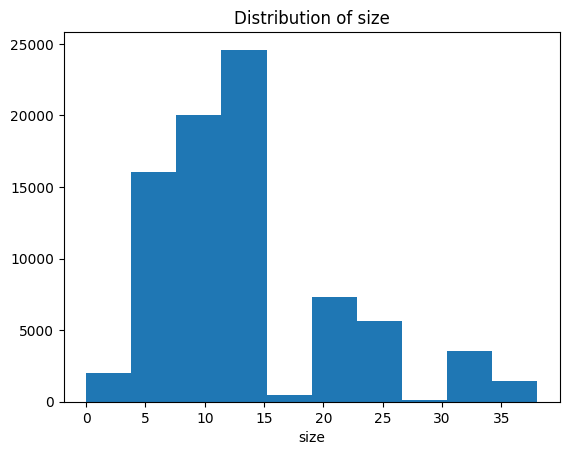

In [9]:
# La variabile "size" assume valori interi tra 0 e 38 e non c'è bisogno di riformattarla essento foramta da valori interi.
print(ModCloth['size'].describe())

plt.hist(ModCloth['size'])
plt.title('Distribution of size')
plt.xlabel('size');

*Quality*

Molti dei capi di abbigliamento sono recensiti positivamente (suppondendo 5 il valore massimo e 1 il minimo).

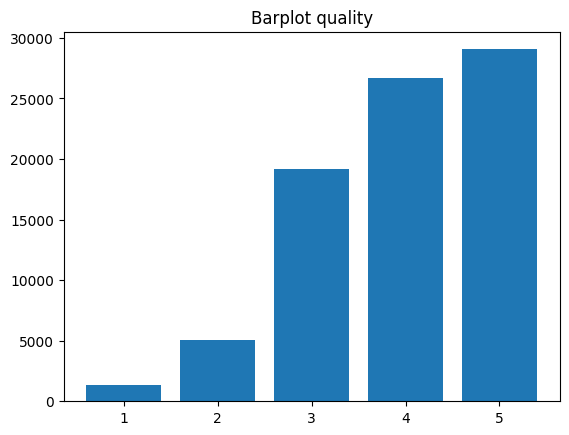

In [10]:
# La variabile "quality" assume i seguenti solamente i valori {1.0, 2.0, 3.0, 4.0, 5.0} perciò la formattiamo come categorica.
ModCloth.quality = ModCloth.quality.astype('category')

label, h = barplot_attr(ModCloth.quality)
plt.bar(label, h)
plt.title('Barplot quality');

*Cup_size*

Notiamo come ci siano delle tipologia di coppe di reggiseno che sono più richieste dalla clientela femminile (es. coppa 'c', coppa 'd') e altre misure che invece sono richieste da una percentuale minima di clienti (es. coppa 'k', coppa 'i').

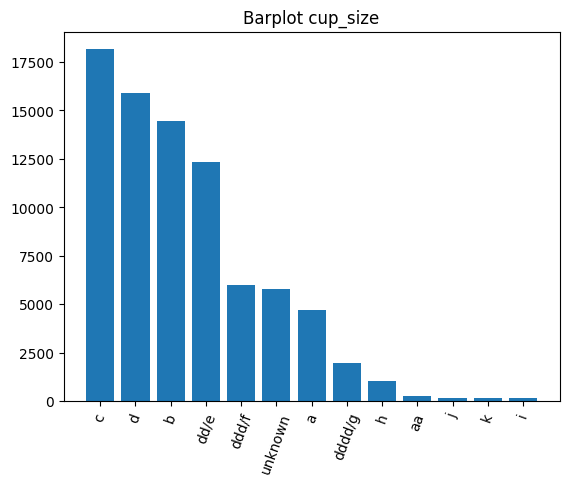

In [11]:
#Questa variabile presenta dei valori mancanti che andiamo a cambiare con il valore 'Unknown' e la consideriamo come categorica.
ModCloth.cup_size = ModCloth.cup_size.fillna('unknown')
ModCloth.cup_size = ModCloth.cup_size.astype('category')

label, h = barplot_attr(ModCloth.cup_size)
plt.bar(label, h)
plt.xticks(rotation=70)
plt.title('Barplot cup_size');

*Hips*

Per questa variabile è presente una elevata quantità di dati mancanti (32%) ma, tra quelli presenti, notiamo una distribuzione di valori che si distribuiscono intoro alla media di 40. 

count    55524.000000
mean        40.354135
std          5.823438
min         30.000000
25%         36.000000
50%         39.000000
75%         43.000000
max         60.000000
Name: hips, dtype: float64

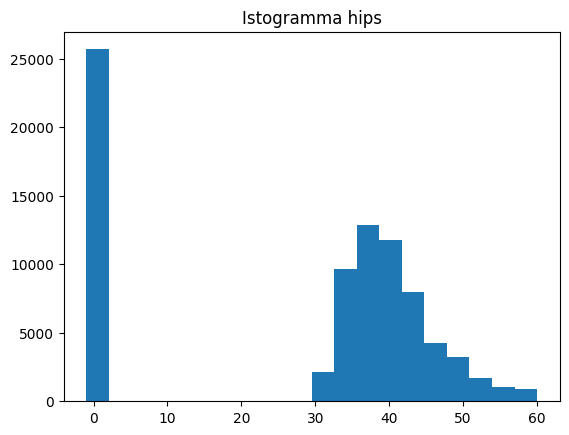

In [12]:
# Valuta il 32% di NA
ModCloth.hips = ModCloth.hips.fillna(-1.0)
ModCloth.hips = ModCloth.hips.astype('float')

display(ModCloth.hips[ModCloth.hips != -1.0].describe())

plt.hist(ModCloth.hips, bins=20)
plt.title('Istogramma hips');

*Bra_size*

Per questa variabile notiamo come il barplot abbia una forma simile a quello della variabile 'cup_size': in seguito approfondiremo questa relazione, essendo entrambe un metro di misura del senso delle donne.

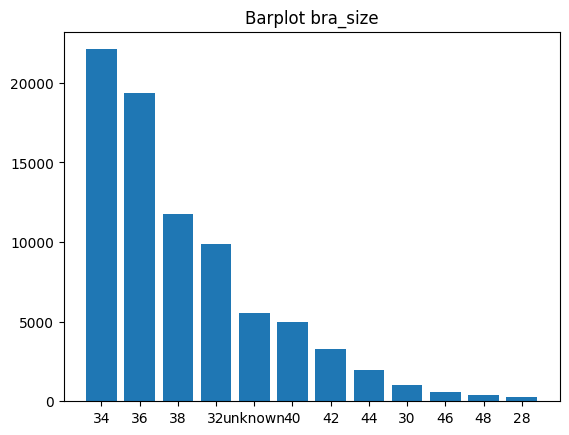

In [13]:
# La variabile "bra_size" essendo formata da taglie la consideriamo come categorica.
ModCloth.bra_size = ModCloth.bra_size.fillna('unknown')
ModCloth.bra_size = ModCloth.bra_size.astype('category')

label, h = barplot_attr(ModCloth.bra_size)
plt.bar(label, h)
plt.title('Barplot bra_size');

*Category*

Questa vairabile ci dice in quale categoria è stato inserito il capo di abbigliamento che è stato recensito: vediamo immediatamente come i nuovi capi sono tra gli acquisti più frequenti seguiti dai top (magliette e camicie) e vestiti interi; stranamente la barra che rappresenta i capi scontati non è molto alta come si potrebbe supporre.

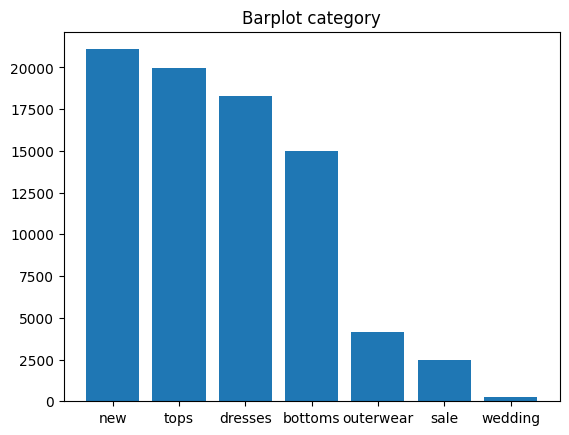

In [14]:
# Anche questa variabile viene formattata come categorica perchè presenta la categoria di apparetenenza del capo.
ModCloth.category = ModCloth.category.astype('category')

label, h = barplot_attr(ModCloth.category)
plt.bar(label, h)
plt.title('Barplot category');

*Height*

Per al misura dell'altezza è normale osservare valori anomali: la maggior parte delle donne ha un altezza intorno alla media (165 cm) ma sono presenti molti casi estremi; l'altezza minima è di 91 cm ceh potrebbe rappresentare l'acquisto di un indumento per una bambina mentre il valore più alto è di 241 cm che molto probabilmente è un errore di scrittura dato che l'attuale donna più alta del mondo misura 215 cm.

count    81219.000000
mean       165.468183
std          7.241443
min         91.440000
25%        160.020000
50%        165.100000
75%        170.180000
max        241.300000
Name: height, dtype: float64

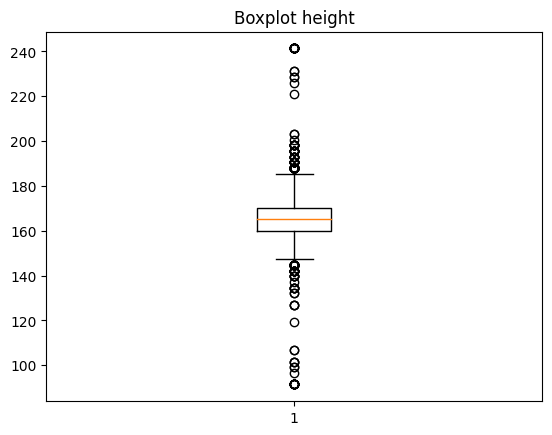

In [15]:
# Assumiamo questa variabile come continua dopo averla trasformata da feet in cm.
def ft_to_cm(x):
    if len(x)>3: 
        return (int(x[0])*30.48) + (int(x[4:-2])*2.54)
    else:
        return (int(x[0])*30.48)

ModCloth.height = ModCloth.height.apply(ft_to_cm)

display(ModCloth.height.describe())

plt.boxplot(ModCloth.height)
plt.title('Boxplot height');

In [16]:
ModCloth[ModCloth.height > 240].groupby('user_name').count()

,item_id,size,quality,cup_size,hips,bra_size,category,height,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text
user_name,,,,,,,,,,,,,,,
Ida,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
bandnerd2522,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
colmaggie,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1


*User_name*

Questa variabile non necessita di riessere formattata e inoltre non presenta nessun valore mancante.

*Length*

Di questa variabile abbiamo eliminato i pochi valori mancanti. Salta subito all'occhio l'elevata frequenza della categoria "just right": la maggior parte degli utenti ha trovato la lunghezza del capo acquistato corretta.

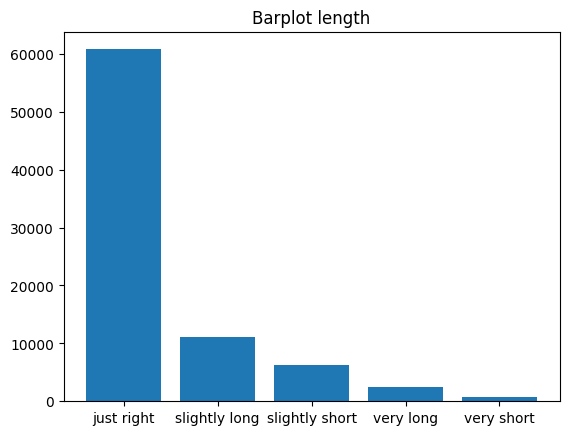

In [17]:
#Variabile che assume valori categorici.
ModCloth.length = ModCloth.length.astype('category')

label, h = barplot_attr(ModCloth.length)
plt.bar(label, h)
plt.title('Barplot length');

*Fit*

Questa variabile non presentava valori mancanti ed è suddivisa in tre categorie delle quali la moda è il fit corretto dell'indumento acquistato. 

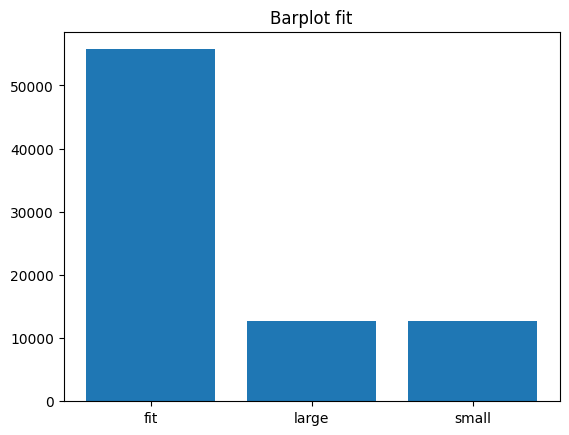

In [18]:
ModCloth.fit = ModCloth.fit.astype('category')

label, h = barplot_attr(ModCloth.fit)
plt.bar(label, h)
plt.title('Barplot fit');

*User_id*

Semplicemente riformattiamo la variabile come intera.

In [19]:
ModCloth.user_id = ModCloth.user_id.astype('int')

*Shoe_size*

In questa variabile molti valori sono mancati: non tutti i capi sono scarpe perciò questo attributo non lo hanno.

È presente un valore anomalo per quanto riguarda questa variabile: 38. Dato che anche in questo caso ci troviamo di fronte a delle taglie, trattiamo questa variabile come categorica ed, essendo solo uno il valore estremo, andiamo a rinominarlo con 'Unknow' per non perdere ulteriori informazioni dell'utente.

C:\Users\mcm23\AppData\Local\Temp\ipykernel_10760\1591780805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ModCloth.shoe_size[idx] = 'Unknown';


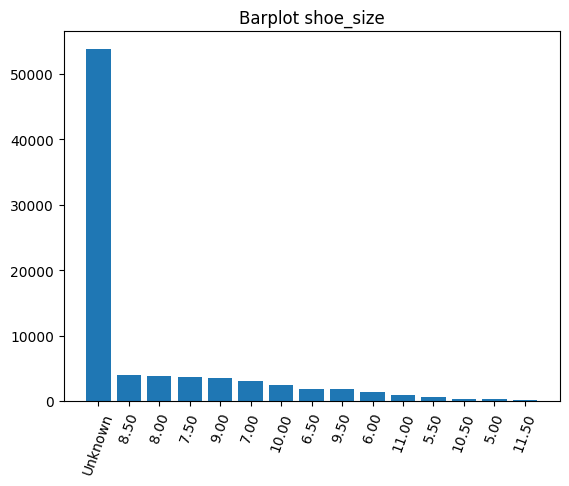

In [20]:
idx = ModCloth.shoe_size[ModCloth.shoe_size == '38'].index[0]
ModCloth.shoe_size[idx] = 'Unknown';

ModCloth.shoe_size = ModCloth.shoe_size.fillna('Unknown')
ModCloth.shoe_size = ModCloth.shoe_size.astype('category')

label, h = barplot_attr(ModCloth.shoe_size)
plt.bar(label, h)
plt.xticks(rotation=70)
plt.title('Barplot shoe_size');

*Shoe_width*

Anche per questa variabile vale in ragionamento fatto per la precendente per quanto riguarda i valori mancanti.

Per questa però troviamo semplicemente tre categorie che con cui l'utente valuta come vestono le scarpe.

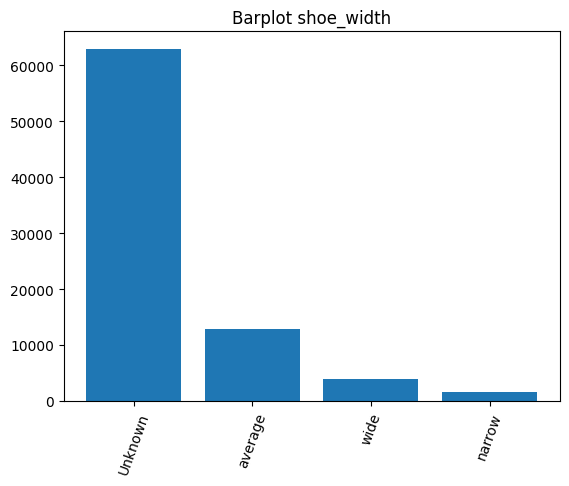

In [21]:
ModCloth.shoe_width = ModCloth.shoe_width.fillna('Unknown')
ModCloth.shoe_width = ModCloth.shoe_width.astype('category')

label, h = barplot_attr(ModCloth.shoe_width)
plt.bar(label, h)
plt.xticks(rotation=70)
plt.title('Barplot shoe_width');

*Review_summary* e *Review_text*

Per queste variabili semplicemente settiamo come 'Unknown' i valori mancanti.

In [22]:
ModCloth.review_summary = ModCloth.review_summary.fillna('Unknown')
ModCloth.review_text = ModCloth.review_text.fillna('Unknown')

In [23]:
# Controlliamo se sono presenti ancora valori mancanti.
ModCloth.isna().sum()

item_id           0
size              0
quality           0
cup_size          0
hips              0
bra_size          0
category          0
height            0
user_name         0
length            0
fit               0
user_id           0
shoe_size         0
shoe_width        0
review_summary    0
review_text       0
dtype: int64

### <u>Preprocessing e Analisi Descrittiva (`MarketBias`)</u>

#### Dataset

During the last few decades, with the rise of Youtube, Amazon, Netflix and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.
In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy or anything else depending on industries).

Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. As a proof of the importance of recommender systems, we can mention that, a few years ago, Netflix organised a challenges (the “Netflix prize”) where the goal was to produce a recommender system that performs better than its own algorithm with a prize of 1 million dollars to win.

Content
These datasets contain attributes about products sold on ModCloth Amazon which may be sources of bias in recommendations (in particular, attributes about how the products are marketed).Data includes user/item interactions.

Inspiration
Apply different paradigm, methods and algorithms to recommand right Product to the right Users, during right Time.

In [4]:
MarketBias.head()

,item_id,user_id,rating,timestamp,size,fit,user_attr,model_attr,category,brand,year,split
0,7443,Alex,4,2010-01-21 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0
1,7443,carolyn.agan,3,2010-01-27 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,2012,0
2,7443,Robyn,4,2010-01-29 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0
3,7443,De,4,2010-02-13 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,2012,0
4,7443,tasha,4,2010-02-18 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0


Variabili:

- **model_attr**: 'Small' indica la presenza di una sola modella che indossa una taglia relativamente piccola del capo , 'Small&Large' indica invece se sono presenti due modelle con taglie differenti;
- **fit**: recensione di come calza il prodotto data da un utente;
- **rating**: valutazione della recensione;
- 


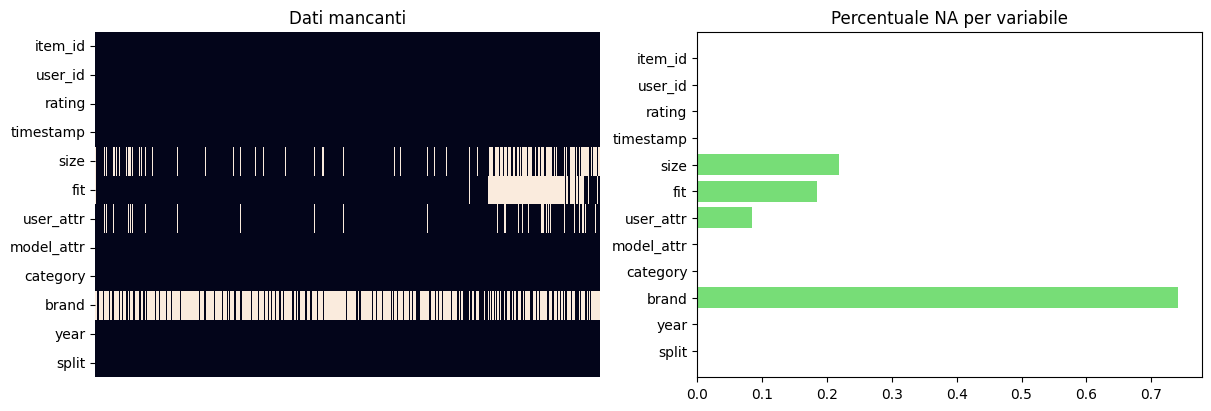

Percentuale di dati mancanti per ogni variabile:


,split,year,brand,category,model_attr,user_attr,fit,size,timestamp,rating,user_id,item_id
0,0.0,0.0,0.740592,0.0,0.0,0.08376,0.185258,0.217833,0.0,0.0,0.00001,0.0


Struttura delle variabili:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99893 entries, 0 to 99892
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item_id     99893 non-null  int64  
 1   user_id     99892 non-null  object 
 2   rating      99893 non-null  int64  
 3   timestamp   99893 non-null  object 
 4   size        78133 non-null  float64
 5   fit         81387 non-null  object 
 6   user_attr   91526 non-null  object 
 7   model_attr  99893 non-null  object 
 8   category    99893 non-null  object 
 9   brand       25913 non-null  object 
 10  year        99893 non-null  int64  
 11  split       99893 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 9.1+ MB


In [5]:
# Visualizzazione valori mancanti.
fig, (ax1, ax2)= plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(12, 4)

# Grafico posizione dati mancati.
sns.heatmap(ax = ax1, data=MarketBias.isna().transpose(), cbar=False)
ax1.set(title='Dati mancanti', xlabel=None)
ax1.set_xticks([])

# Grafico percentuale dati mancanti.
perc_NA = pd.DataFrame(MarketBias.isna().sum() / MarketBias.shape[0])[::-1]
ax2.barh(np.arange(len(perc_NA.index)), perc_NA[0].to_list(), color = '#77DD77')
ax2.set(title='Percentuale NA per variabile')
ax2.set_yticks(np. arange(len(perc_NA)), perc_NA.index)
plt.show()


print('Percentuale di dati mancanti per ogni variabile:')
display(perc_NA.T)

print('Struttura delle variabili:')
MarketBias.info()

Solo 4 delle 12 variabili presentano valori mancanti (user_id ha un solo valore mancante ed eliminiamo la riga).

La variabile brand ha più del 70% di valori mancanti: probabilmente non la useremo.

In [9]:
# Non ci sono righe che si ripetono.
MarketBias.duplicated().sum()

0

#### Variabili

*Item_id*

Questa variabile è già formattata come intera e non presenta valori mancanti.

*User_id*

È presente una sola riga con un valore mancante per questa variabile che andiamo ad eliminare.

In [27]:
idx = MarketBias[MarketBias.user_id.isna()].index
MarketBias.drop(index=idx, inplace=True)

*Rating*

La variabile 'rating' non presenta nessun valore mancante. La moda di questa variabile è il valore più alto (supponendo 5 il migliore e 1 il peggiore).

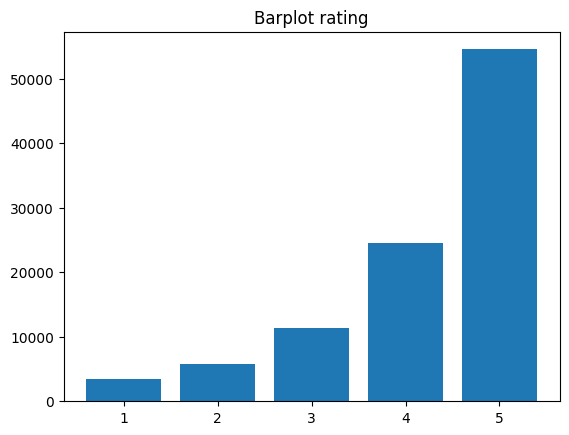

In [28]:
label, h = barplot_attr(MarketBias.rating)

plt.bar(label, h)
plt.title('Barplot rating');

*Time_stamp*

Ricodifichiamo la variabile in formato datetime.

In [29]:
MarketBias.timestamp = pd.to_datetime(MarketBias.timestamp)

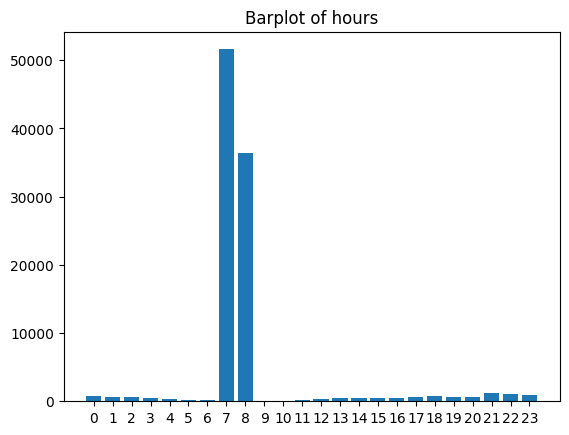

In [52]:
label, h = barplot_attr(pd.DatetimeIndex(MarketBias.timestamp).hour)
plt.bar(label, h)
plt.xticks(label)
plt.title('Barplot of hours');

*Size*

(array([21760.,    83., 15195., 18211., 17752.,  7388.,  7759.,  6004.,
         3793.,  1948.]),
 array([-1. , -0.1,  0.8,  1.7,  2.6,  3.5,  4.4,  5.3,  6.2,  7.1,  8. ]),
 <BarContainer object of 10 artists>)

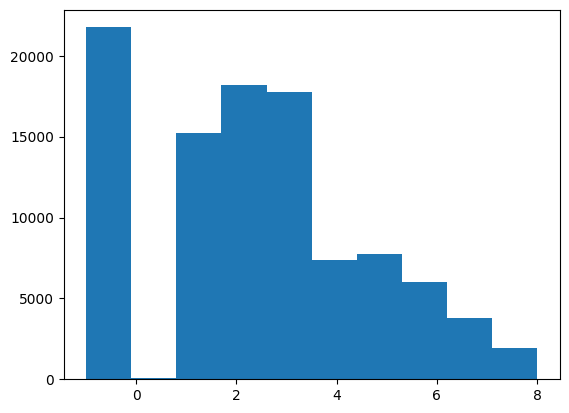

In [17]:
# Set as categorical or continuos?
MarketBias['size'] = MarketBias['size'].fillna(-1.0)
plt.hist(MarketBias['size'])



*Fit*

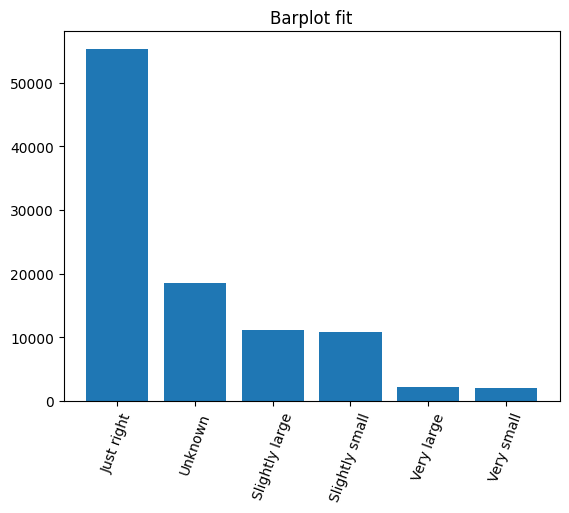

In [24]:
MarketBias.fit = MarketBias.fit.fillna('Unknown')
MarketBias.fit = MarketBias.fit.astype('category')

label, h = barplot_attr(MarketBias.fit)
plt.bar(label, h)
plt.xticks(rotation=70)
plt.title('Barplot fit');

*User_attr*

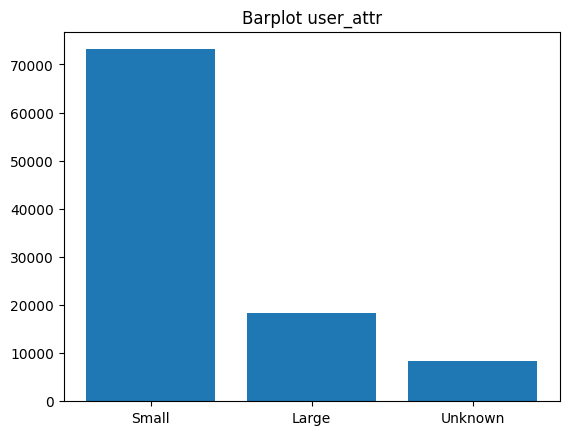

In [27]:
MarketBias.user_attr = MarketBias.user_attr.fillna('Unknown')
MarketBias.user_attr = MarketBias.user_attr.astype('category')

label, h = barplot_attr(MarketBias.user_attr)
plt.bar(label, h)
plt.title('Barplot user_attr');

*Model_attr*

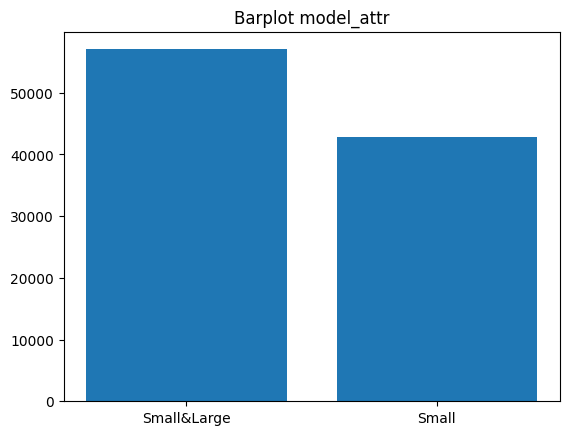

In [64]:
MarketBias.model_attr = MarketBias.model_attr.astype('category')

label, h = barplot_attr(MarketBias.model_attr)
plt.bar(label, h)
plt.title('Barplot model_attr');

*Category*

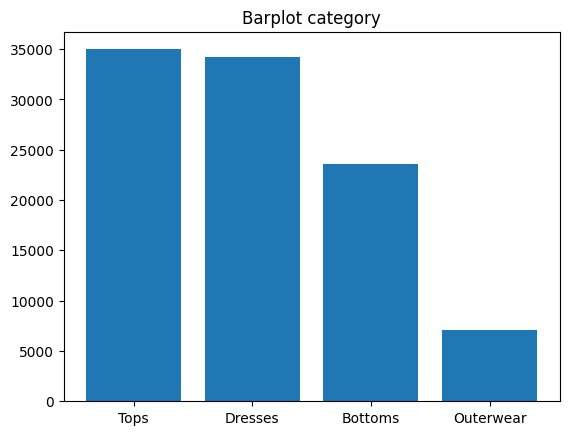

In [62]:
MarketBias.category = MarketBias.category.astype('category')

label, h = barplot_attr(MarketBias.category)
plt.bar(label, h)
plt.title('Barplot category');

*Brand*

Questa variabile presenta il 74% di valori mancanti: decidiamo perciò di non considerarla.

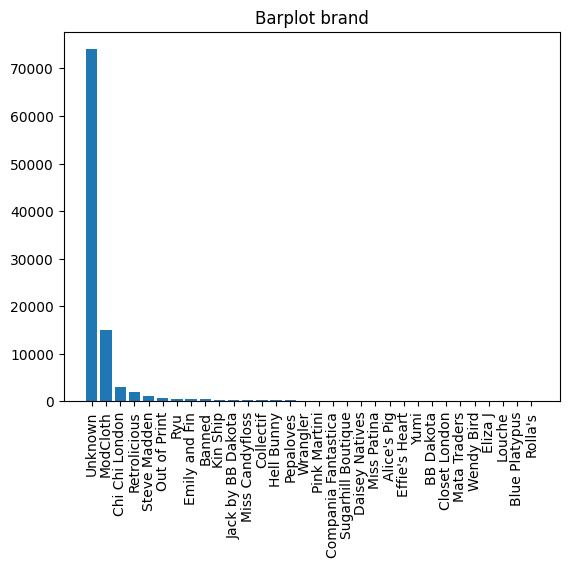

In [34]:
MarketBias.brand = MarketBias.brand.fillna('Unknown')
MarketBias.brand = MarketBias.brand.astype('category')

label, h = barplot_attr(MarketBias.brand)
plt.bar(label, h)
plt.xticks(rotation=90)
plt.title('Barplot brand');

In [38]:
MarketBias[MarketBias.brand == 'ModCloth'].groupby('user_id').count()

,item_id,rating,timestamp,size,fit,user_attr,model_attr,category,brand,year,split
user_id,,,,,,,,,,,
"""Ferrari"")",1,1,1,1,1,1,1,1,1,1,1
#,1,1,1,1,0,1,1,1,1,1,1
'Chelle,2,2,2,2,1,2,2,2,2,2,2
-L,1,1,1,1,1,1,1,1,1,1,1
..,1,1,1,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
zoiekate,1,1,1,0,1,1,1,1,1,1,1
zombie66_79,1,1,1,1,1,1,1,1,1,1,1
zombiscuit,1,1,1,1,1,1,1,1,1,1,1


*Year*

Questa variabile ci presenta l'anno in cui l'acquisto è stato effettuato: vediamo come non ci sia un andamento regolare ma sono presenti alcuni anni in cui il numero di acquisti è molto elevato (es. 2015, 2016).

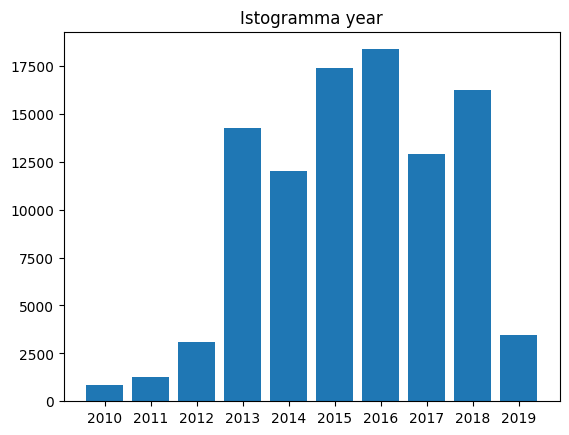

In [54]:
label, h = barplot_attr(MarketBias.year)
plt.bar(label, h)
plt.xticks(label)
plt.title('Istogramma year');

*Split*

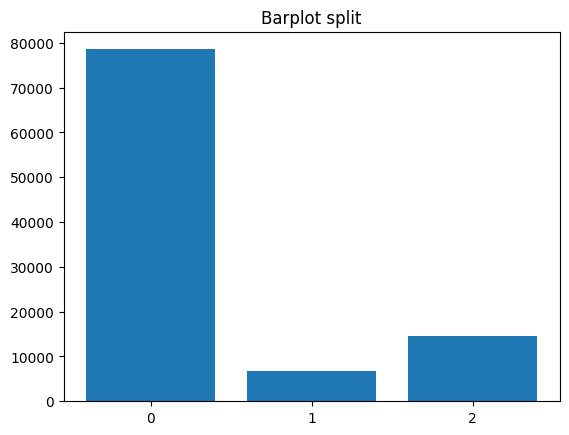

In [41]:
label, h = barplot_attr(MarketBias.split)
plt.bar(label,h)
plt.xticks(label)
plt.title('Barplot split');

---
## 2) Identificazione della configurazione ottimale dell’algoritmo K-NN per la predizione dei rating
In questo punto dovranno quindi essere testate le diverse combinazioni: distanza, valore di K, user/item based. Tramite le diverse metriche di performance (MSE e RMSE) individuare di conseguenza la configurazione ottimale. 

---
## 3) Filling della matrice di rating con la configurazione ottimale

---
## 4) Segmentazione degli utenti in base alle preferenze: algoritmo di clustering K-MEANS con cosine similarity

---
## 5)  Creare per ogni utente la lista degli n items da consigliare (es. considerando il rating predetto)

---
## 6) Filling della matrice di rating attraverso Matrix Factorization in aggiunta a K-NN e confronto dei risultati ottenuti in termini di MSE e RMSE